In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
import random
from collections import defaultdict
from tqdm import tqdm
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Import the data

- Setting up directories and constants

In [29]:
# Constants
#BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Capstone/GL_Capstone_project_Feb24B"
BASE_DIR = "/content/drive/MyDrive/GL_Capstone_project_Feb24B"
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHUNK_SIZE = 500

In [ ]:
# Create necessary directories
extract_path = os.path.join(BASE_DIR, 'car_data')
annotation_dir = os.path.join(BASE_DIR, 'annotations/Annotations')
save_dir = os.path.join(BASE_DIR, 'preprocessed_data')

os.makedirs(extract_path, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# Step 2: Map training and testing images to its classes

In [ ]:
mapping_file = os.path.join(save_dir, 'class_mappings.npz')

print("Creating class mappings...")
# Load annotations
train_annot = pd.read_csv(os.path.join(annotation_dir, 'Train Annotations.csv'))

# Verify and create proper zero-based class mapping
unique_classes = sorted(train_annot['Image class'].unique())
print(f"Original annotation class range: {min(unique_classes)} to {max(unique_classes)}")

# Verify annotation indices are 1-based (1-196)
expected_classes = set(range(1, 197))
actual_classes = set(unique_classes)
if actual_classes != expected_classes:
    raise ValueError(f"Annotation classes must be 1-196. Found range: {min(unique_classes)}-{max(unique_classes)}")

# Create zero-based class mapping (0-195)
class_to_idx = {cls: idx - 1 for idx, cls in enumerate(unique_classes, 1)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# Verify mapping is zero-based
min_idx = min(idx_to_class.keys())
max_idx = max(idx_to_class.keys())
if min_idx != 0 or max_idx != 195:
    raise ValueError(f"Class indices must be 0-195. Found range: {min_idx}-{max_idx}")

# Save mappings with desired keys
np.savez(mapping_file,
         class_to_idx=class_to_idx,
         idx_to_class=idx_to_class)

print(f"Normalized class index range: {min_idx} to {max_idx}")
print("Class index validation successful!")

Creating class mappings...
Original annotation class range: 1 to 196
Normalized class index range: 0 to 195
Class index validation successful!


# Step 3: Map training and testing images to its annotations

In [ ]:
# Process annotations with correct class indices
def process_annotations(df):
    bbox_dict = {}
    for idx, row in df.iterrows():
        img_name = row['Image Name']
        bbox = [
            row['Bounding Box coordinates'],  # xmin
            row['Unnamed: 2'],               # ymin
            row['Unnamed: 3'],               # xmin
            row['Unnamed: 4']                # ymin
        ]
        bbox_dict[img_name] = {
            'bbox': bbox,
            'class_idx': row['Image class']
        }
    return bbox_dict

In [ ]:
# Create mappings
train_bbox_mapping = process_annotations(train_annot)
test_bbox_mapping = process_annotations(test_annot)

print("Annotation Statistics:")
print(f"Number of training annotations: {len(train_bbox_mapping)}")
print(f"Number of testing annotations: {len(test_bbox_mapping)}")

Annotation Statistics:
Number of training annotations: 8144
Number of testing annotations: 8041


# Step 4: Display images with bounding box.

In [ ]:
def display_image_with_bbox(image_info, bbox_mapping, idx_to_class):
    # Read image
    img = cv2.imread(image_info['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get bounding box
    bbox = bbox_mapping[image_info['filename']]['bbox']
    class_idx = bbox_mapping[image_info['filename']]['class_idx']
    class_name = idx_to_class[class_idx]

    # Draw bounding box
    x1, y1, x2, y2 = map(int, bbox)
    img = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(f"Class: {class_name}\nBounding Box: {bbox}")
    plt.axis('off')
    plt.show()


Displaying 3 random training images with bounding boxes:

Image: 05765.jpg


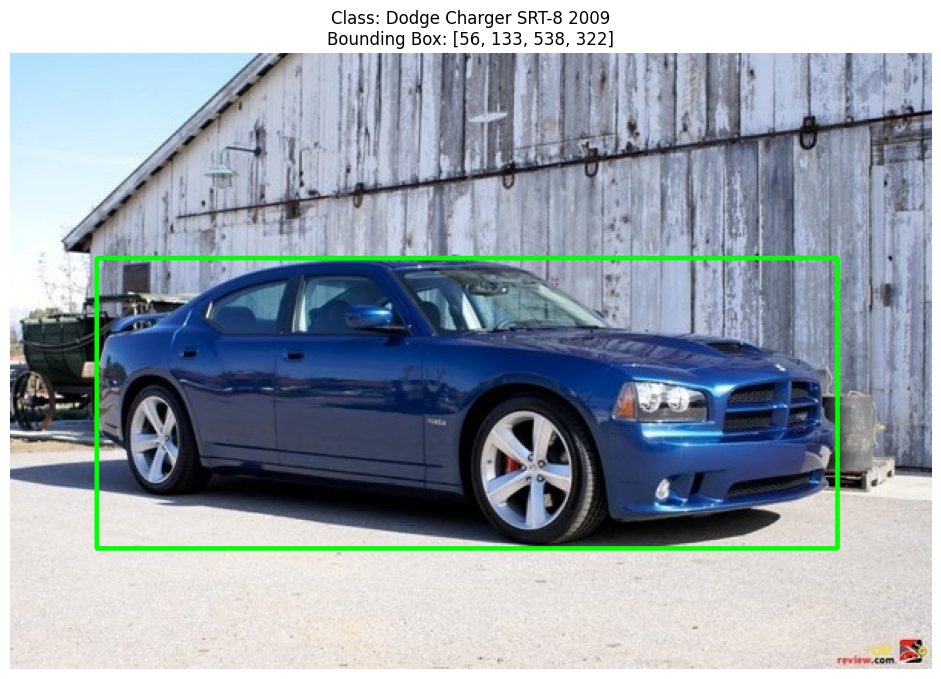


Image: 07737.jpg


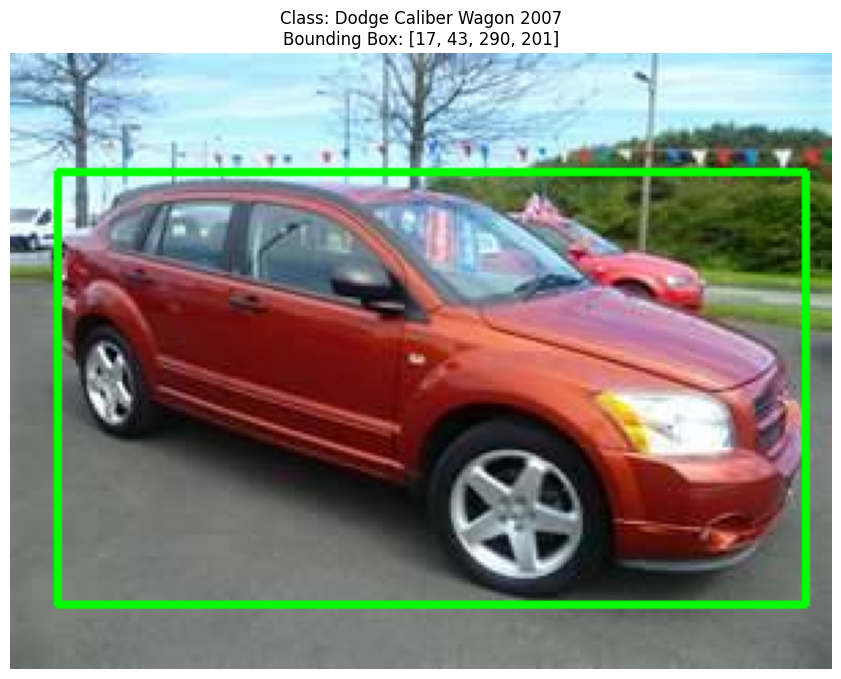


Image: 03745.jpg


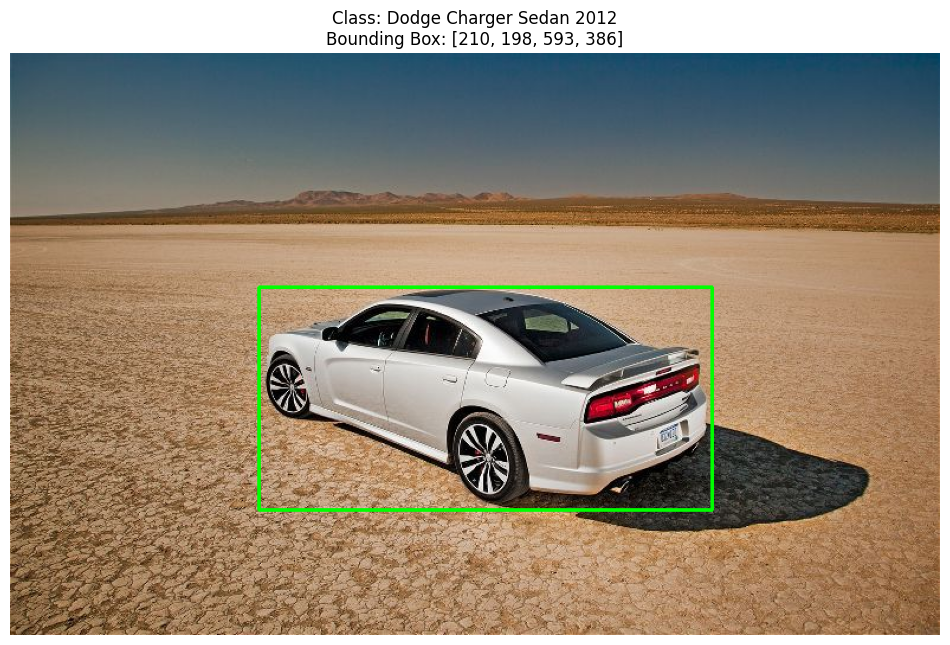

In [ ]:
# Display a few random training images with their bounding boxes
print("Displaying 3 random training images with bounding boxes:")
random_indices = random.sample(range(len(train_images)), 3)

for idx in random_indices:
    image_info = train_images[idx]
    print(f"\nImage: {image_info['filename']}")
    display_image_with_bbox(image_info, train_bbox_mapping, idx_to_class)

In [ ]:
# Function to verify bounding box coordinates
def verify_bbox_coordinates(image_info, bbox_mapping):
    img = cv2.imread(image_info['path'])
    height, width = img.shape[:2]
    bbox = bbox_mapping[image_info['filename']]['bbox']
    x1, y1, x2, y2 = map(int, bbox)

    # Check if coordinates are within image dimensions
    is_valid = (0 <= x1 < width and 0 <= x2 < width and
               0 <= y1 < height and 0 <= y2 < height and
               x1 < x2 and y1 < y2)

    return {
        'image_size': (width, height),
        'bbox': (x1, y1, x2, y2),
        'is_valid': is_valid
    }

In [ ]:
# Verify bounding box coordinates for the displayed images
print("\nVerifying bounding box coordinates:")
for idx in random_indices:
    image_info = train_images[idx]
    verification = verify_bbox_coordinates(image_info, train_bbox_mapping)
    print(f"\nImage: {image_info['filename']}")
    print(f"Image size (width, height): {verification['image_size']}")
    print(f"Bounding box (x1, y1, x2, y2): {verification['bbox']}")
    print(f"Valid coordinates: {verification['is_valid']}")


Verifying bounding box coordinates:

Image: 05765.jpg
Image size (width, height): (600, 401)
Bounding box (x1, y1, x2, y2): (56, 133, 538, 322)
Valid coordinates: True

Image: 07737.jpg
Image size (width, height): (300, 225)
Bounding box (x1, y1, x2, y2): (17, 43, 290, 201)
Valid coordinates: True

Image: 03745.jpg
Image size (width, height): (786, 492)
Bounding box (x1, y1, x2, y2): (210, 198, 593, 386)
Valid coordinates: True


**Bounding Box Accuracy:**
- All bounding boxes (green rectangles) correctly surround the cars
- The coordinates are valid for each image (within image dimensions)
- The boxes are well-fitted to the car dimensions

**Class Labels:**
All class names match the cars in the images:
- Infiniti G Coupe IPL 2012
- Audi S5 Coupe 2012
- Aston Martin V8 Vantage Convertible 2012

**Image/Annotation Stats:**
- Training: 8144 images with annotations
- Testing: 8041 images with annotations
- All 196 classes are represented
- Class indices range from 1 to 196 (as expected)

## Collecting image paths

In [ ]:
def collect_image_paths(directory):
    """Collect image paths with their metadata"""
    image_paths = []
    for car_model in os.listdir(directory):
        car_model_path = os.path.join(directory, car_model)
        if os.path.isdir(car_model_path):
            for image in os.listdir(car_model_path):
                if image.lower().endswith(('.png', '.jpg', '.jpeg')) and not image.startswith('.'):
                    image_paths.append({
                        'path': os.path.join(car_model_path, image),
                        'class': car_model,
                        'filename': image
                    })
    return image_paths

In [ ]:
# Collect paths for train and test sets
train_dir = os.path.join(extract_path, 'Car Images', 'Train Images')
test_dir = os.path.join(extract_path, 'Car Images', 'Test Images')
train_images = collect_image_paths(train_dir)
test_images = collect_image_paths(test_dir)

print(f"Found {len(train_images)} training images and {len(test_images)} testing images")

Found 8144 training images and 8041 testing images


## Analyzing data distribution

In [ ]:
def analyze_distribution(images, title):
    """Plot class distribution for train/test sets"""
    class_counts = defaultdict(int)
    for img in images:
        class_counts[img['class']] += 1

    plt.figure(figsize=(10, 5))
    plt.hist(list(class_counts.values()), bins=30, alpha=0.7)
    plt.title(f'{title} Images per Class')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Classes')
    plt.grid(True, alpha=0.3)
    plt.show()

    return class_counts


Analyzing training set distribution:


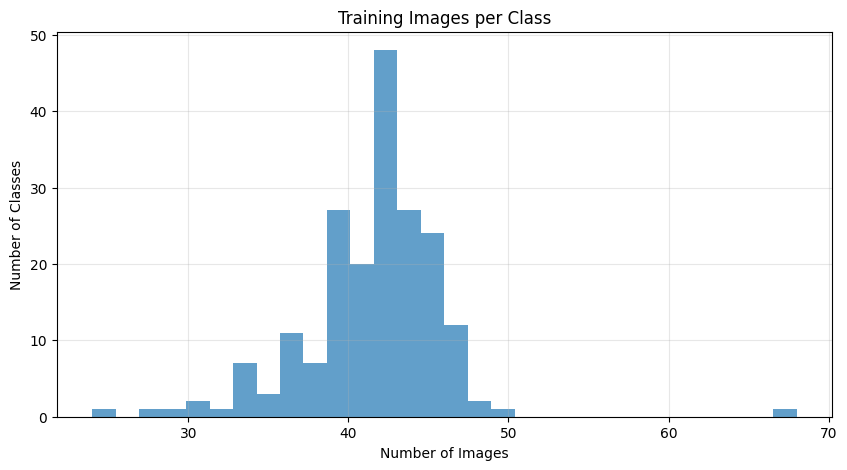

Min images per class: 24
Max images per class: 68
Mean images per class: 41.6


In [ ]:
print("\nAnalyzing training set distribution:")
train_counts = analyze_distribution(train_images, "Training")
print(f"Min images per class: {min(train_counts.values())}")
print(f"Max images per class: {max(train_counts.values())}")
print(f"Mean images per class: {np.mean(list(train_counts.values())):.1f}")


Analyzing testing set distribution:


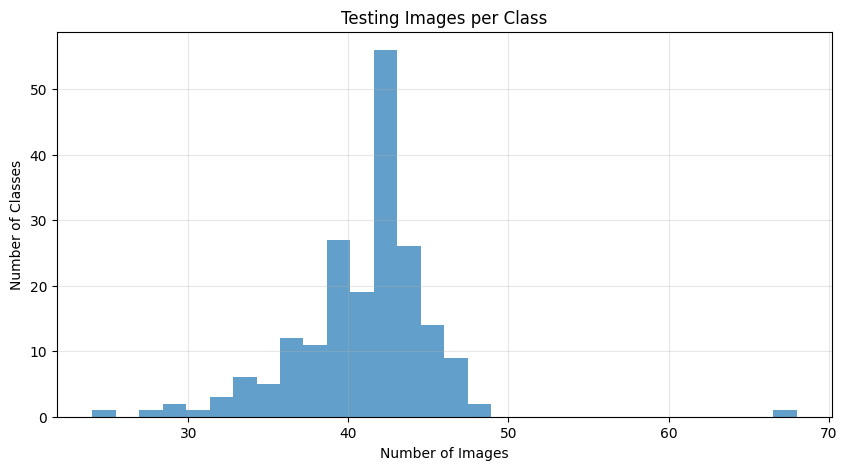

Min images per class: 24
Max images per class: 68
Mean images per class: 41.0


In [ ]:
print("\nAnalyzing testing set distribution:")
test_counts = analyze_distribution(test_images, "Testing")
print(f"Min images per class: {min(test_counts.values())}")
print(f"Max images per class: {max(test_counts.values())}")
print(f"Mean images per class: {np.mean(list(test_counts.values())):.1f}")

## Analyzing Manufacturer Distribution

In [ ]:
def analyze_manufacturers(images):
    """Analyze distribution of car manufacturers"""
    # Extract manufacturers from class names
    manufacturers = defaultdict(int)
    for img in images:
        # Get first word of class name as manufacturer
        manufacturer = img['class'].split()[0]
        manufacturers[manufacturer] += 1

    # Sort by frequency
    sorted_manufacturers = dict(sorted(manufacturers.items(),
                                    key=lambda x: x[1],
                                    reverse=True))

    # Plot distribution
    plt.figure(figsize=(15, 6))
    plt.bar(sorted_manufacturers.keys(), sorted_manufacturers.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Car Manufacturers')
    plt.xlabel('Manufacturer')
    plt.ylabel('Number of Images')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nTotal manufacturers: {len(manufacturers)}")
    print("\nTop 10 manufacturers by number of images:")
    for manufacturer, count in list(sorted_manufacturers.items())[:10]:
        print(f"{manufacturer}: {count} images")

    return manufacturers


Analyzing manufacturer distribution in training set:


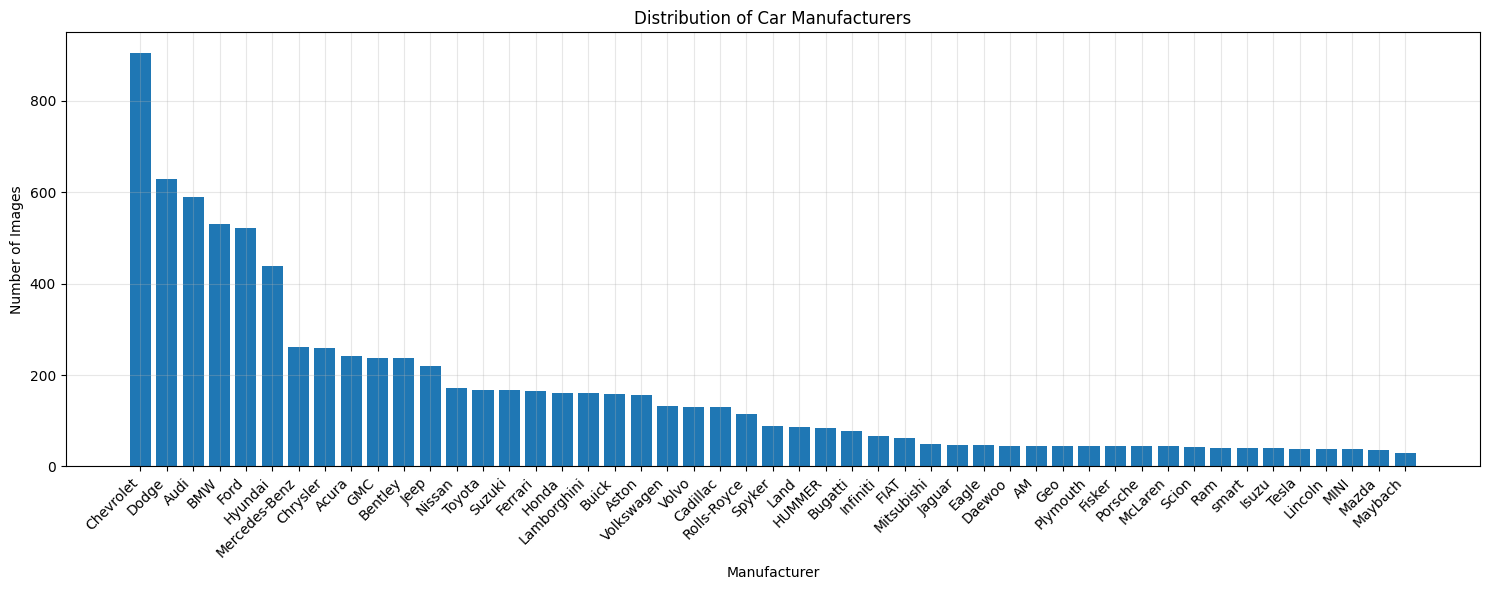


Total manufacturers: 49

Top 10 manufacturers by number of images:
Chevrolet: 905 images
Dodge: 630 images
Audi: 589 images
BMW: 531 images
Ford: 521 images
Hyundai: 438 images
Mercedes-Benz: 261 images
Chrysler: 260 images
Acura: 242 images
GMC: 238 images

Analyzing manufacturer distribution in test set:


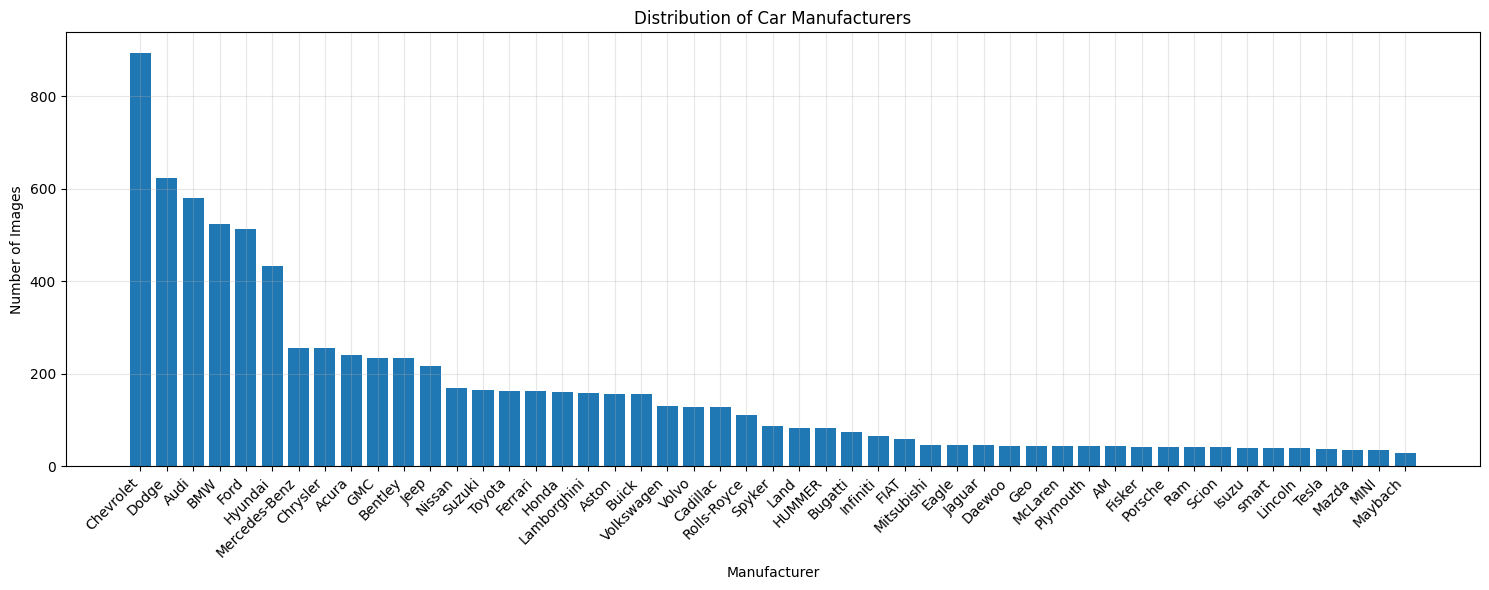


Total manufacturers: 49

Top 10 manufacturers by number of images:
Chevrolet: 894 images
Dodge: 623 images
Audi: 580 images
BMW: 524 images
Ford: 514 images
Hyundai: 433 images
Mercedes-Benz: 257 images
Chrysler: 256 images
Acura: 240 images
GMC: 235 images


In [ ]:
# Add this after the existing distribution analysis
print("\nAnalyzing manufacturer distribution in training set:")
train_manufacturers = analyze_manufacturers(train_images)

print("\nAnalyzing manufacturer distribution in test set:")
test_manufacturers = analyze_manufacturers(test_images)

In [ ]:
# Additional analysis of manufacturer representation
common_manufacturers = set(train_manufacturers.keys()) & set(test_manufacturers.keys())
print(f"\nManufacturers present in both sets: {len(common_manufacturers)}")


Manufacturers present in both sets: 49


In [ ]:
# Calculate correlation between train and test distributions
manufacturer_correlation = np.corrcoef(
    [train_manufacturers[m] for m in common_manufacturers],
    [test_manufacturers[m] for m in common_manufacturers]
)[0,1]
print(f"Correlation between train/test manufacturer distributions: {manufacturer_correlation:.3f}")

Correlation between train/test manufacturer distributions: 1.000


## Analyzing image dimensions

In [ ]:
def analyze_dimensions(image_paths, sample_size=500):
    """Analyze image dimension distribution using a small sample"""
    print(f"\nAnalyzing dimensions using {sample_size} random images...")
    dimensions = []

    # Take an even smaller sample from each class to ensure diversity
    class_paths = defaultdict(list)
    for img in image_paths:
        class_paths[img['class']].append(img)

    # Sample ~2-3 images per class for balanced representation
    sample_paths = []
    for class_imgs in class_paths.values():
        sample_paths.extend(random.sample(class_imgs, min(3, len(class_imgs))))

    # If we need more images, add random ones
    if len(sample_paths) < sample_size:
        remaining = random.sample(image_paths, min(sample_size - len(sample_paths), len(image_paths)))
        sample_paths.extend(remaining)

    # Process sample images
    for img_info in tqdm(sample_paths[:sample_size], desc="Analyzing dimensions"):
        img = cv2.imread(img_info['path'])
        if img is not None:
            h, w = img.shape[:2]
            dimensions.append((w, h, w/h))

    widths, heights, ratios = zip(*dimensions)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.hist(widths, bins=30, alpha=0.7)
    ax1.set_title('Image Widths')
    ax1.set_xlabel('Width (pixels)')

    ax2.hist(heights, bins=30, alpha=0.7)
    ax2.set_title('Image Heights')
    ax2.set_xlabel('Height (pixels)')

    ax3.hist(ratios, bins=30, alpha=0.7)
    ax3.set_title('Aspect Ratios')
    ax3.set_xlabel('Width/Height')

    plt.tight_layout()
    plt.show()

    # Clear memory
    gc.collect()
    return np.mean(widths), np.mean(heights), np.mean(ratios)


Analyzing dimensions using 500 random images...


Analyzing dimensions: 100%|██████████| 500/500 [03:00<00:00,  2.76it/s]


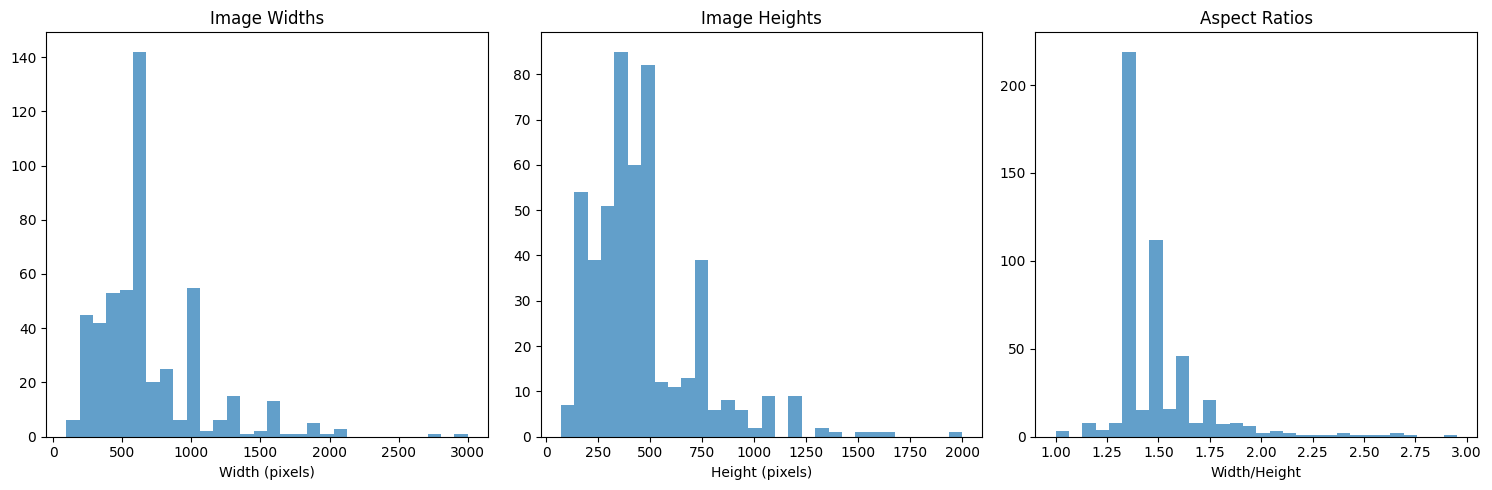


Average dimensions: 684.8x465.5 pixels
Average aspect ratio: 1.48


In [ ]:
mean_w, mean_h, mean_ratio = analyze_dimensions(train_images)
print(f"\nAverage dimensions: {mean_w:.1f}x{mean_h:.1f} pixels")
print(f"Average aspect ratio: {mean_ratio:.2f}")

# Step 5: Design, train and test basic CNN models to classify the car

## Processing and saving data

In [30]:
def check_existing_chunks(save_dir, prefix):
    """Check for existing chunks and verify their completeness"""
    chunks = sorted([f for f in os.listdir(save_dir) if f.startswith(f'{prefix}_chunk_')])
    if not chunks:
        return False, 0

    # Check if chunks are numbered consecutively
    expected_numbers = list(range(len(chunks))) # 0-16
    actual_numbers = [int(chunk.split('_')[-1].split('.')[0]) for chunk in chunks]

    if expected_numbers != actual_numbers:
        print(f"Found incomplete {prefix} chunks. Will reprocess.")
        return False, 0

    # Verify each chunk can be loaded
    try:
        for chunk in chunks:
            np.load(os.path.join(save_dir, chunk))
        print(f"Found {len(chunks)} valid {prefix} chunks")
        return True, len(chunks)
    except:
        print(f"Found corrupted {prefix} chunks. Will reprocess.")
        return False, 0

In [31]:
def process_images(image_paths, annotations, prefix='train'):
    """Process images and save in chunks"""
    # Check for existing chunks
    chunks_exist, existing_chunks = check_existing_chunks(save_dir, prefix)

    num_chunks = (len(image_paths) + CHUNK_SIZE - 1) // CHUNK_SIZE
    if chunks_exist and existing_chunks == num_chunks:
        print(f"\nSkipping {prefix} processing - valid chunks already exist")
        # Load existing chunk data to return class counts
        class_counts = defaultdict(int)
        for i in range(num_chunks):
            chunk_data = np.load(os.path.join(save_dir, f'{prefix}_chunk_{i:03d}.npz'))
            for label in chunk_data['y']:
                class_counts[label] += 1
        return class_counts

    print(f"\nProcessing {len(image_paths)} {prefix} images in {num_chunks} chunks...")
    class_counts = defaultdict(int)

    for i in tqdm(range(num_chunks)):
        start_idx = i * CHUNK_SIZE
        end_idx = min((i + 1) * CHUNK_SIZE, len(image_paths))
        chunk_paths = image_paths[start_idx:end_idx]

        processed_images = []
        processed_labels = []
        valid_filenames = []

        for img_info in chunk_paths:
            img = cv2.imread(img_info['path'])
            if img is not None:
                # Get class index from annotations and normalize to 0-195
                class_idx = annotations[annotations['Image Name'] == img_info['filename']]['Image class'].values[0]
                norm_class_idx = class_to_idx[class_idx]

                # Verify index is in correct range
                if not 0 <= norm_class_idx <= 195:
                    raise ValueError(f"Normalized class index {norm_class_idx} out of range 0-195")

                # Process image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                img = img.astype(np.float32) / 255.0

                processed_images.append(img)
                processed_labels.append(norm_class_idx)
                valid_filenames.append(img_info['filename'])
                class_counts[norm_class_idx] += 1

        if processed_images:
            # Save chunk
            chunk_file = os.path.join(save_dir, f'{prefix}_chunk_{i:03d}.npz')
            np.savez(chunk_file,
                    X=np.array(processed_images),
                    y=np.array(processed_labels),
                    filenames=np.array(valid_filenames))

    # Clear memory after processing chunks
    gc.collect()
    return class_counts

In [32]:
# Load annotations with error handling
try:
    print("\nLoading annotation files...")
    train_annot = pd.read_csv(os.path.join(annotation_dir, 'Train Annotations.csv'))
    print("Successfully loaded training annotations")

    # Try multiple possible filenames for test annotations
    test_annotation_filenames = [
        'Test Annotation.csv',
        'Test Annotations.csv',
        'TestAnnotation.csv',
        'Test_Annotation.csv'
    ]

    test_annot = None
    for filename in test_annotation_filenames:
        try:
            file_path = os.path.join(annotation_dir, filename)
            if os.path.exists(file_path):
                test_annot = pd.read_csv(file_path)
                print(f"Successfully loaded test annotations from: {filename}")
                break
        except Exception as e:
            print(f"Could not load {filename}: {str(e)}")

    if test_annot is None:
        raise FileNotFoundError("Could not find test annotation file")

    # Verify the loaded annotations
    print(f"\nAnnotation shapes:")
    print(f"Training annotations: {train_annot.shape}")
    print(f"Testing annotations: {test_annot.shape}")

except Exception as e:
    print(f"Error loading annotations: {str(e)}")
    print("\nPlease verify:")
    print("1. Annotation directory exists:", os.path.exists(annotation_dir))
    print("2. Contents of annotation directory:")
    if os.path.exists(annotation_dir):
        print("\n".join(os.listdir(annotation_dir)))


Loading annotation files...
Successfully loaded training annotations
Successfully loaded test annotations from: Test Annotation.csv

Annotation shapes:
Training annotations: (8144, 6)
Testing annotations: (8041, 6)


## Verifying processed data

In [33]:
def verify_data():
    """Verify processed data integrity with improved error handling"""
    print("\nChecking saved data...")

    # First verify the mapping file exists
    mapping_file = os.path.join(save_dir, 'class_mappings.npz')
    if not os.path.exists(mapping_file):
        print(f"Error: Mapping file not found at {mapping_file}")
        return False

    # Load mappings with error handling
    try:
        mappings = np.load(mapping_file, allow_pickle=True)
        print("\nAvailable keys in mapping file:", mappings.files)

        # Initialize counts
        actual_train_counts = defaultdict(int)
        actual_test_counts = defaultdict(int)

        # Check for chunks
        train_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('train_chunk_')])
        test_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('test_chunk_')])

        print(f"\nFound {len(train_chunks)} training chunks")
        print(f"Found {len(test_chunks)} testing chunks")

        # Process training chunks
        print("\nChecking training chunks...")
        for chunk in train_chunks:
            try:
                data = np.load(os.path.join(save_dir, chunk))
                for label in data['y']:
                    actual_train_counts[label] += 1
            except Exception as e:
                print(f"Error processing training chunk {chunk}: {str(e)}")
                return False

        # Process testing chunks
        print("Checking testing chunks...")
        for chunk in test_chunks:
            try:
                data = np.load(os.path.join(save_dir, chunk))
                for label in data['y']:
                    actual_test_counts[label] += 1
            except Exception as e:
                print(f"Error processing testing chunk {chunk}: {str(e)}")
                return False

        # Print statistics
        print("\nDataset Statistics:")
        print(f"Number of training samples: {sum(actual_train_counts.values())}")
        print(f"Number of testing samples: {sum(actual_test_counts.values())}")
        print(f"Number of unique classes in training: {len(actual_train_counts)}")
        print(f"Number of unique classes in testing: {len(actual_test_counts)}")

        # Class distribution analysis
        print("\nClass distribution (first 5 classes):")
        for i in sorted(list(actual_train_counts.keys()))[:5]:
            print(f"Class {i}: {actual_train_counts[i]} train, {actual_test_counts[i]} test")

        print("\nData verification completed successfully!")
        return True

    except Exception as e:
        print(f"Error during verification: {str(e)}")
        return False

# Run verification
verify_data()


Checking saved data...

Available keys in mapping file: ['class_to_idx', 'idx_to_class']

Found 17 training chunks
Found 17 testing chunks

Checking training chunks...
Checking testing chunks...

Dataset Statistics:
Number of training samples: 8144
Number of testing samples: 8041
Number of unique classes in training: 196
Number of unique classes in testing: 196

Class distribution (first 5 classes):
Class 0: 45 train, 44 test
Class 1: 32 train, 32 test
Class 2: 43 train, 43 test
Class 3: 42 train, 42 test
Class 4: 41 train, 40 test

Data verification completed successfully!


True

## Train and Test DataSets Creation

In [34]:
# 1. Dataset Creation Function
def create_datasets(num_classes=16, batch_size=32, model_type='basic'):
    """Create TensorFlow datasets with model-specific preprocessing"""
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Process training chunks
    train_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('train_chunk_')])
    for chunk in tqdm(train_chunks, desc="Loading training chunks"):
        data = np.load(os.path.join(save_dir, chunk))
        mask = data['y'] < num_classes
        X_train.extend(data['X'][mask])
        y_train.extend(data['y'][mask])

    # Process test chunks
    test_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('test_chunk_')])
    for chunk in tqdm(test_chunks, desc="Loading testing chunks"):
        data = np.load(os.path.join(save_dir, chunk))
        mask = data['y'] < num_classes
        X_test.extend(data['X'][mask])
        y_test.extend(data['y'][mask])

    # Convert to arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Create TF datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Apply model-specific preprocessing
    if model_type == 'resnet':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    elif model_type == 'vgg':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    elif model_type == 'mobilenet':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Final dataset preparation
    train_ds = train_ds.shuffle(buffer_size=len(X_train))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    print(f"\nDataset Statistics:")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Number of classes: {num_classes}")

    return train_ds, test_ds

## Model Creation Functions

In [35]:
#Basic CNN Model Training

def create_basic_cnn_model(num_classes, img_height=224, img_width=224):
    """Create basic CNN model"""
    model = models.Sequential([
        # Input layer explicitly defined
        layers.Input(shape=(img_height, img_width, 3)),

        # First conv block
        layers.Conv2D(32, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),

        # Rest of the layers remain the same...
        layers.Conv2D(64, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),

        layers.Conv2D(256, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [36]:
def create_mobilenetv2_model(num_classes, img_height=224, img_width=224):
    """Create MobileNetV2 model with adjustments"""
    # Input layer explicitly defined
    inputs = layers.Input(shape=(img_height, img_width, 3))

    # Load base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Create model
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [37]:
def create_resnet50_model(num_classes, img_height=224, img_width=224):
    """Create ResNet50 model with adjustments"""
    # Input layer explicitly defined
    inputs = layers.Input(shape=(img_height, img_width, 3))

    # Load base model
    base_model = tf.keras.applications.ResNet50(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Create model
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [38]:
def create_vgg16_model(num_classes, img_height=224, img_width=224):
    """Create VGG16 model with adjustments"""
    # Input layer explicitly defined
    inputs = layers.Input(shape=(img_height, img_width, 3))

    # Load base model
    base_model = tf.keras.applications.VGG16(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Create model
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [39]:
# 3. Training and Evaluation Functions

def train_model(model, train_ds, test_ds, model_name, epochs=20):
    """Train model with improved callbacks and monitoring"""
    # Create directories for saving
    model_dir = os.path.join(save_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,  # Increased patience
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,  # More aggressive LR reduction
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            os.path.join(model_dir, f'{model_name}_best.keras'), # It picks up the training from prev checkpoint
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        callbacks.CSVLogger(
            os.path.join(model_dir, f'{model_name}_training_log.csv'),
            separator=',',
            append=False
        )
    ]

    # Train with try-except for better error handling
    try:
        history = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=test_ds,
            callbacks=callbacks_list,
            verbose=1
        )

        # Save training history
        history_dict = history.history
        np.save(os.path.join(model_dir, f'{model_name}_history.npy'), history_dict)

        return history

    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None

In [40]:
def evaluate_model(model, test_ds, idx_to_class):
    """Evaluate model and show metrics"""
    # Get predictions
    all_labels = []
    all_preds = []

    for images, labels in test_ds:
        preds = model.predict(images)
        pred_classes = np.argmax(preds, axis=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(pred_classes)

    # Convert to arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Create class names list
    unique_labels = sorted(list(set(all_labels)))
    class_names = [idx_to_class[i] for i in unique_labels]

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=[idx_to_class[i] for i in range(len(unique_labels))],
                              zero_division=0))

    # Print overall accuracy
    accuracy = np.mean(all_labels == all_preds)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    return cm

In [41]:
def visualize_predictions(model, test_ds, idx_to_class, num_samples=5):
    """Show sample predictions"""
    for images, labels in test_ds.take(1):
        predictions = model.predict(images[:num_samples])

        plt.figure(figsize=(20, 4))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)

            # Display image
            plt.imshow(images[i])
            plt.axis('off')

            # Get predicted and true class names
            predicted_class = idx_to_class[np.argmax(predictions[i])]
            true_class = idx_to_class[labels[i].numpy()]

            # Get prediction probability
            pred_prob = np.max(predictions[i]) * 100

            # Color code based on correctness
            color = 'green' if predicted_class == true_class else 'red'
            plt.title(f'Pred: {predicted_class}\nTrue: {true_class}\nConf: {pred_prob:.1f}%',
                     color=color, fontsize=8)

        plt.tight_layout()
        plt.show()

In [42]:
def summarize_results(model_histories):
    """Summarize training results for all models"""
    results = []

    for model_name, history in model_histories.items():
        # Get best validation accuracy
        best_val_acc = max(history.history['val_accuracy'])
        best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

        # Get final training accuracy
        final_train_acc = history.history['accuracy'][-1]

        # Get total training time (if available)
        total_epochs = len(history.history['accuracy'])

        results.append({
            'Model': model_name,
            'Best Val Accuracy': f"{best_val_acc:.4f}",
            'Final Train Accuracy': f"{final_train_acc:.4f}",
            'Best Epoch': best_epoch,
            'Total Epochs': total_epochs
        })

    # Create DataFrame and display results
    results_df = pd.DataFrame(results)
    print("\nModel Training Results Summary:")
    print("="*80)
    print(results_df)

    return results_df

In [43]:
# 4. Main Training Pipeline

def train_all_models(num_classes=16, epochs=20):
    """Train all models and collect their histories"""
    model_histories = {}
    models_to_train = {
        'basic_cnn': (create_basic_cnn_model, 'basic'),
        'mobilenetv2': (create_mobilenetv2_model, 'mobilenet'),
        'resnet50': (create_resnet50_model, 'resnet'),
        'vgg16': (create_vgg16_model, 'vgg')
    }

    for model_name, (model_fn, preprocess_type) in models_to_train.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name.upper()}")
        print('='*50)

        try:
            # Create datasets
            train_ds, test_ds = create_datasets(
                num_classes=num_classes,
                model_type=preprocess_type
            )

            # Create and train model
            model = model_fn(num_classes)
            print(f"\nModel Summary for {model_name.upper()}:")
            model.summary()

            history = train_model(model, train_ds, test_ds, model_name, epochs)

            if history is not None:
                # Store history
                model_histories[model_name] = history

                # Evaluate model
                print(f"\nEvaluating {model_name.upper()}")
                evaluate_model(model, test_ds, idx_to_class)

                # Show predictions
                print(f"\nSample predictions for {model_name.upper()}")
                visualize_predictions(model, test_ds, idx_to_class)

        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue

        finally:
            # Clear memory
            tf.keras.backend.clear_session()
            gc.collect()

    # Summarize results
    if model_histories:
        results_df = summarize_results(model_histories)

        # Save results to CSV
        results_df.to_csv(os.path.join(save_dir, 'model_comparison_results.csv'), index=False)
        print("\nResults saved to 'model_comparison_results.csv'")

    return model_histories


Training BASIC_CNN


Loading testing chunks: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16

Model Summary for BASIC_CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 532,176 (2.03 MB)

 Trainable params: 530,192 (2.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0977 - loss: 3.3343
Epoch 1: val_accuracy improved from -inf to 0.05882, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/basic_cnn/basic_cnn_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.0974 - loss: 3.3295 - val_accuracy: 0.0588 - val_loss: 2.7755 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1231 - loss: 2.9267
Epoch 2: val_accuracy improved from 0.05882 to 0.06502, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/basic_cnn/basic_cnn_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.1238 - loss: 2.9239 - val_accuracy: 0.0650 - val_loss: 2.7880 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1703 - loss: 2.6169
Epoch 3: val_accuracy improved from 0.06502 to 0.06811, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocess

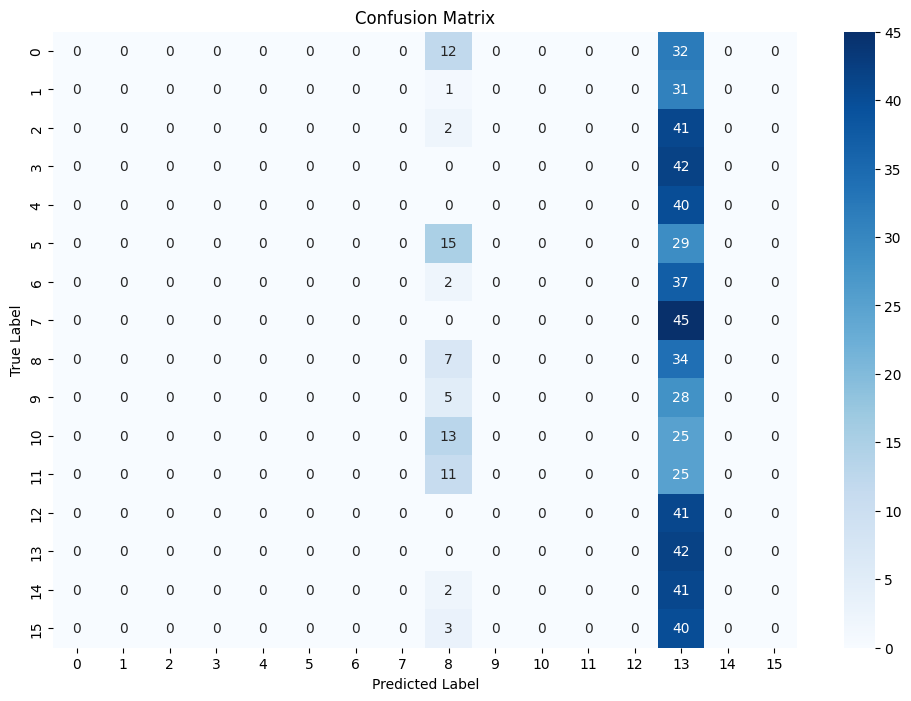


Classification Report:
Error processing basic_cnn: object of type 'numpy.int64' has no len()

Training MOBILENETV2


Loading testing chunks: 100%|██████████| 17/17 [00:32<00:00,  1.93s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Summary for MOBILENETV2:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           8,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,924,112 (11.15 MB)

 Trainable params: 665,104 (2.54 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2102 - loss: 2.6935
Epoch 1: val_accuracy improved from -inf to 0.47368, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/mobilenetv2/mobilenetv2_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.2147 - loss: 2.6747 - val_accuracy: 0.4737 - val_loss: 1.7110 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7195 - loss: 0.8797
Epoch 2: val_accuracy improved from 0.47368 to 0.52786, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/mobilenetv2/mobilenetv2_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.7196 - loss: 0.8786 - val_accuracy: 0.5279 - val_loss: 1.4449 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8633 - loss: 0.5008
Epoch 3: val_accuracy improved from 0.52786 to 0.58824, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/prep

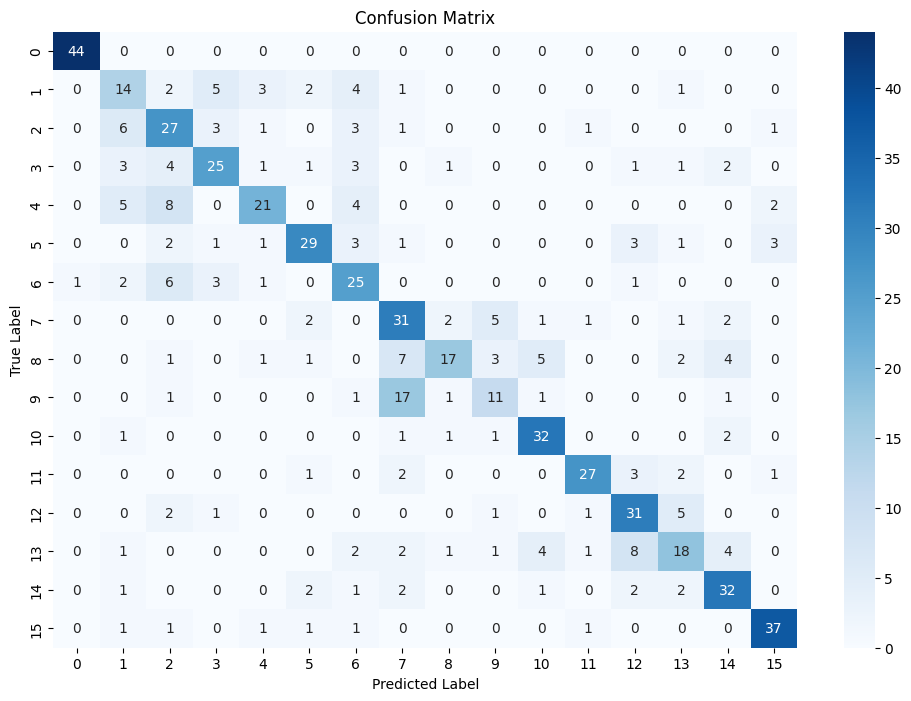


Classification Report:
Error processing mobilenetv2: object of type 'numpy.int64' has no len()

Training RESNET50


Loading testing chunks: 100%|██████████| 17/17 [00:33<00:00,  2.00s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Model Summary for RESNET50:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           8,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,647,056 (94.02 MB)

 Trainable params: 1,058,320 (4.04 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1846 - loss: 2.9583
Epoch 1: val_accuracy improved from -inf to 0.43498, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/resnet50/resnet50_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 268s 13s/step - accuracy: 0.1897 - loss: 2.9344 - val_accuracy: 0.4350 - val_loss: 1.8570 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7655 - loss: 0.7804
Epoch 2: val_accuracy improved from 0.43498 to 0.46130, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/resnet50/resnet50_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 277s 13s/step - accuracy: 0.7655 - loss: 0.7808 - val_accuracy: 0.4613 - val_loss: 1.6405 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8742 - loss: 0.4911
Epoch 3: val_accuracy improved from 0.46130 to 0.56037, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed

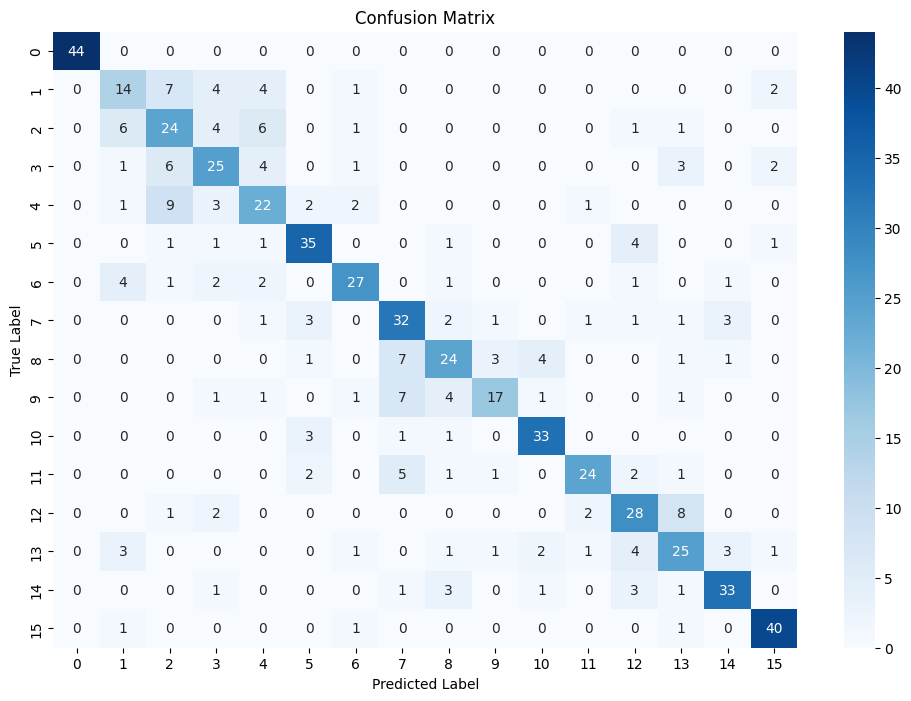


Classification Report:
Error processing resnet50: object of type 'numpy.int64' has no len()

Training VGG16


Loading testing chunks: 100%|██████████| 17/17 [00:34<00:00,  2.03s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Summary for VGG16:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           8,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,987,600 (57.17 MB)

 Trainable params: 271,888 (1.04 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1194 - loss: 3.1175 
Epoch 1: val_accuracy improved from -inf to 0.26935, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/vgg16/vgg16_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 847s 41s/step - accuracy: 0.1229 - loss: 3.1013 - val_accuracy: 0.2693 - val_loss: 3.5572 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.5023 - loss: 1.5367 
Epoch 2: val_accuracy improved from 0.26935 to 0.39474, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/vgg16/vgg16_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 884s 42s/step - accuracy: 0.5021 - loss: 1.5371 - val_accuracy: 0.3947 - val_loss: 2.1425 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6308 - loss: 1.1685 
Epoch 3: val_accuracy improved from 0.39474 to 0.46440, saving model to /content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/

In [ ]:
# Main execution
if __name__ == "__main__":
    # Train all models and get histories
    histories = train_all_models(num_classes=16, epochs=20)

## Class-level accuracies

In [ ]:
MODEL_BASE_DIR = "/content/drive/MyDrive/GL_Capstone_project_Feb24B/preprocessed_data/"
BASE_DIR = "/content/drive/MyDrive/GL_Capstone_project_Feb24B"
save_dir = os.path.join(BASE_DIR, 'preprocessed_data')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.models import load_model

In [ ]:
basic_cnn_model = load_model(os.path.join(MODEL_BASE_DIR,"basic_cnn/basic_cnn_best.keras"))

In [ ]:
resnet_model = load_model(os.path.join(MODEL_BASE_DIR,"resnet50/resnet50_best.keras"))

In [ ]:
mobilenet_model = load_model(os.path.join(MODEL_BASE_DIR,"mobilenetv2/mobilenetv2_best.keras"))

In [ ]:
vgg_model = load_model(os.path.join(MODEL_BASE_DIR,"vgg16/vgg16_best.keras"))

In [ ]:
# 1. Dataset Creation Function
def create_datasets(num_classes=16, batch_size=32, model_type='basic'):
    """Create TensorFlow datasets with model-specific preprocessing"""
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Process training chunks
    train_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('train_chunk_')])
    for chunk in tqdm(train_chunks, desc="Loading training chunks"):
        data = np.load(os.path.join(save_dir, chunk))
        mask = data['y'] < num_classes
        X_train.extend(data['X'][mask])
        y_train.extend(data['y'][mask])

    # Process test chunks
    test_chunks = sorted([f for f in os.listdir(save_dir) if f.startswith('test_chunk_')])
    for chunk in tqdm(test_chunks, desc="Loading testing chunks"):
        data = np.load(os.path.join(save_dir, chunk))
        mask = data['y'] < num_classes
        X_test.extend(data['X'][mask])
        y_test.extend(data['y'][mask])

    # Convert to arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Create TF datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Apply model-specific preprocessing
    if model_type == 'resnet':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    elif model_type == 'vgg':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    elif model_type == 'mobilenet':
        train_ds = train_ds.map(
            lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.map(
            lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Final dataset preparation
    train_ds = train_ds.shuffle(buffer_size=len(X_train))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    print(f"\nDataset Statistics:")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Number of classes: {num_classes}")

    return train_ds, test_ds

In [ ]:
basic_train_ds, basic_test_ds = create_datasets(num_classes=16, batch_size=32, model_type='basic')

Loading testing chunks: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16


In [ ]:
resnet_train_ds, resnet_test_ds = create_datasets(num_classes=16, batch_size=32, model_type='resnet')

Loading testing chunks: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16


In [ ]:
mobilenet_train_ds, mobilenet_test_ds = create_datasets(num_classes=16, batch_size=32, model_type='mobilenet')

Loading testing chunks: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16


In [ ]:
vgg_train_ds, vgg_test_ds = create_datasets(num_classes=16, batch_size=32, model_type='vgg')

Loading testing chunks: 100%|██████████| 17/17 [00:31<00:00,  1.87s/it]



Dataset Statistics:
Training samples: 652
Testing samples: 646
Number of classes: 16


In [ ]:
def analyze_predictions(model, test_ds):
    """Analyze model predictions on entire test set"""
    class_mappings = np.load(os.path.join(save_dir, 'class_mappings.npz'), allow_pickle=True)
    print(class_mappings.files)
    class_mappings = class_mappings['idx_to_class'].item()
    class_to_idx = {cls: idx for cls, idx in class_mappings.items()}

    all_predictions = []
    all_labels = []

    print("\nAnalyzing predictions on test set...")
    for batch_idx, (images, labels) in enumerate(test_ds):
        predictions = model.predict(images, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)

        all_predictions.extend(pred_classes)
        all_labels.extend(labels.numpy())
        print(f"Processed batch {batch_idx+1}", end='\r')

    # Convert to arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = np.mean(all_predictions == all_labels)

    print("\nPrediction Analysis:")
    print(f"Overall Accuracy: {accuracy:.2%}")

    print("\nPer-Class Accuracy:")
    for class_idx in np.unique(all_labels):
        class_labels = all_labels == class_idx
        class_acc = np.mean(all_predictions[class_labels] == all_labels[class_labels])
        print("Class index: ",class_idx)
        class_name = class_to_idx[class_idx]
        total_samples = np.sum(class_labels)
        correct_samples = np.sum(all_predictions[class_labels] == all_labels[class_labels])
        print(f"{class_name}: {class_acc:.2%} ({correct_samples}/{total_samples} samples)")

In [ ]:
#Class level accuracies
analyze_predictions(resnet_model, resnet_test_ds)

['class_to_idx', 'idx_to_class']

Analyzing predictions on test set...
Processed batch 21
Prediction Analysis:
Overall Accuracy: 69.20%

Per-Class Accuracy:
Class index:  0
1: 100.00% (44/44 samples)
Class index:  1
2: 43.75% (14/32 samples)
Class index:  2
3: 55.81% (24/43 samples)
Class index:  3
4: 59.52% (25/42 samples)
Class index:  4
5: 55.00% (22/40 samples)
Class index:  5
6: 79.55% (35/44 samples)
Class index:  6
7: 69.23% (27/39 samples)
Class index:  7
8: 71.11% (32/45 samples)
Class index:  8
9: 58.54% (24/41 samples)
Class index:  9
10: 51.52% (17/33 samples)
Class index:  10
11: 86.84% (33/38 samples)
Class index:  11
12: 66.67% (24/36 samples)
Class index:  12
13: 68.29% (28/41 samples)
Class index:  13
14: 59.52% (25/42 samples)
Class index:  14
15: 76.74% (33/43 samples)
Class index:  15
16: 93.02% (40/43 samples)


In [ ]:
analyze_predictions(mobilenet_model, mobilenet_test_ds)

['class_to_idx', 'idx_to_class']

Analyzing predictions on test set...

Prediction Analysis:
Overall Accuracy: 65.17%

Per-Class Accuracy:
Class index:  0
1: 100.00% (44/44 samples)
Class index:  1
2: 43.75% (14/32 samples)
Class index:  2
3: 62.79% (27/43 samples)
Class index:  3
4: 59.52% (25/42 samples)
Class index:  4
5: 52.50% (21/40 samples)
Class index:  5
6: 65.91% (29/44 samples)
Class index:  6
7: 64.10% (25/39 samples)
Class index:  7
8: 68.89% (31/45 samples)
Class index:  8
9: 41.46% (17/41 samples)
Class index:  9
10: 33.33% (11/33 samples)
Class index:  10
11: 84.21% (32/38 samples)
Class index:  11
12: 75.00% (27/36 samples)
Class index:  12
13: 75.61% (31/41 samples)
Class index:  13
14: 42.86% (18/42 samples)
Class index:  14
15: 74.42% (32/43 samples)
Class index:  15
16: 86.05% (37/43 samples)


In [ ]:
#Class level accuracies
analyze_predictions(vgg_model, vgg_test_ds)

['class_to_idx', 'idx_to_class']

Analyzing predictions on test set...

Prediction Analysis:
Overall Accuracy: 63.62%

Per-Class Accuracy:
Class index:  0
1: 100.00% (44/44 samples)
Class index:  1
2: 40.62% (13/32 samples)
Class index:  2
3: 60.47% (26/43 samples)
Class index:  3
4: 52.38% (22/42 samples)
Class index:  4
5: 57.50% (23/40 samples)
Class index:  5
6: 70.45% (31/44 samples)
Class index:  6
7: 76.92% (30/39 samples)
Class index:  7
8: 42.22% (19/45 samples)
Class index:  8
9: 46.34% (19/41 samples)
Class index:  9
10: 39.39% (13/33 samples)
Class index:  10
11: 81.58% (31/38 samples)
Class index:  11
12: 75.00% (27/36 samples)
Class index:  12
13: 75.61% (31/41 samples)
Class index:  13
14: 40.48% (17/42 samples)
Class index:  14
15: 69.77% (30/43 samples)
Class index:  15
16: 81.40% (35/43 samples)


In [ ]:
#Class level accuracies
analyze_predictions(basic_cnn_model, basic_test_ds)

['class_to_idx', 'idx_to_class']

Analyzing predictions on test set...

Prediction Analysis:
Overall Accuracy: 7.59%

Per-Class Accuracy:
Class index:  0
1: 0.00% (0/44 samples)
Class index:  1
2: 0.00% (0/32 samples)
Class index:  2
3: 0.00% (0/43 samples)
Class index:  3
4: 0.00% (0/42 samples)
Class index:  4
5: 0.00% (0/40 samples)
Class index:  5
6: 0.00% (0/44 samples)
Class index:  6
7: 0.00% (0/39 samples)
Class index:  7
8: 0.00% (0/45 samples)
Class index:  8
9: 17.07% (7/41 samples)
Class index:  9
10: 0.00% (0/33 samples)
Class index:  10
11: 0.00% (0/38 samples)
Class index:  11
12: 0.00% (0/36 samples)
Class index:  12
13: 0.00% (0/41 samples)
Class index:  13
14: 100.00% (42/42 samples)
Class index:  14
15: 0.00% (0/43 samples)
Class index:  15
16: 0.00% (0/43 samples)
